# Training an Anomalous Jet Detector with **AE** 

---
In this notebook, we train an unsupervised algorithm capable of compressing a jet features into a low-dimension laten space and, from there, reconstruct the input data. The distance between the input and the output is used to identify rare jets. Applying a lower treshold on the loss, one can veto standard QCD jets (quarks and gluons) and select a sample enriched in anomalous jets (W, Z, top, etc). 

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [3]:
! git clone https://github.com/pierinim/tutorials.git

Cloning into 'tutorials'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 609 (delta 15), reused 25 (delta 10), pack-reused 579
Receiving objects: 100% (609/609), 546.80 MiB | 13.49 MiB/s, done.
Resolving deltas: 100% (217/217), done.
Checking out files: 100% (54/54), done.


In [4]:
! ls tutorials/Data/JetDataset/

jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [5]:
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]


Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 16)


In [6]:
# we standardize the data, so that the mean is = 0 and rms = 1 
from sklearn.preprocessing import StandardScaler
print(np.mean(features[:,10]), np.var(features[:,10]))
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
print(np.mean(features[:,10]), np.var(features[:,10]))

0.08990890900131082 0.0013334328255667934
6.394884621840902e-19 1.0000000000000036


We now separate the dataset in 4:
- a training dataset, consisting of quarks and gluons
- three 'anomalous jets' samples: W, Z, and top

In [7]:
features_standard = features[np.argmax(target,axis=1)<2]
features_W = features[np.argmax(target,axis=1)==2]
features_Z = features[np.argmax(target,axis=1)==3]
features_t = features[np.argmax(target,axis=1)==4]
print(features_standard.shape, features_W.shape, features_Z.shape, features_t.shape)

(19908, 16) (10015, 16) (10037, 16) (10040, 16)


Notice that this is an unsupervised algorithm, so we don't need the target array anymore.
Nevertheless, we keep a part of it around, since it might be useful to test the response 
of the algorithm to quarks and gluons separetly

In [8]:
label_standard = target[np.argmax(target,axis=1)<2]

We now shuffle the standard-jet data and its labels, splitting them into a training, a validation+test dataset with 2:1:1 ratio. 

Then we separate the validation+test in two halves (training and validation)

In [9]:
from sklearn.model_selection import train_test_split
X_learn, X_test, label_learn, label_test = train_test_split(features_standard, label_standard, test_size=0.2)
print(X_learn.shape, X_test.shape, label_learn.shape, label_test.shape)
X_train, X_val, label_train, label_val = train_test_split(X_learn, label_learn, test_size=0.2)
print(X_train.shape, X_val.shape, label_train.shape, label_val.shape, label_test.shape)
del features_standard, label_standard, features, target, X_learn, label_learn

(15926, 16) (3982, 16) (15926, 5) (3982, 5)
(12740, 16) (3186, 16) (12740, 5) (3186, 5) (3982, 5)


# Building the AE model

In [11]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import setGPU

setGPU: Setting GPU to: 1


In [12]:
#---------
# Enncoder
#---------
inputLayer = Input(shape=(16))
#
enc = Dense(10)(inputLayer)
enc = Activation('elu')(enc)
#
enc = Dense(5)(enc)
enc = Activation('elu')(enc)

#---------
# Decoder
#---------
dec = Dense(10)(enc)
dec = Activation('elu')(dec)
#
dec = Dense(16)(dec)
autoencoder = Model(inputs=inputLayer, outputs=dec)

In [13]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                170       
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
activation_2 (Activation)    (None, 10)               

We now train the model. Notice the difference with respect to the supervised case
- the input to the training is (X,X) and nor (X, y). Similarly for the validation dataset
- the model has no dropout. It is difficult for an unsupervised model to overtran, so there is not really a need

In [14]:
batch_size = 128
n_epochs = 100

In [15]:
# train 
history = autoencoder.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, X_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/100
100/100 - 0s - loss: 1.0113 - val_loss: 0.7173
Epoch 2/100
100/100 - 0s - loss: 0.5623 - val_loss: 0.4261
Epoch 3/100
100/100 - 0s - loss: 0.3328 - val_loss: 0.2595
Epoch 4/100
100/100 - 0s - loss: 0.2072 - val_loss: 0.1674
Epoch 5/100
100/100 - 0s - loss: 0.1427 - val_loss: 0.1245
Epoch 6/100
100/100 - 0s - loss: 0.1116 - val_loss: 0.1021
Epoch 7/100
100/100 - 0s - loss: 0.0946 - val_loss: 0.0892
Epoch 8/100
100/100 - 0s - loss: 0.0842 - val_loss: 0.0809
Epoch 9/100
100/100 - 0s - loss: 0.0771 - val_loss: 0.0749
Epoch 10/100
100/100 - 0s - loss: 0.0717 - val_loss: 0.0700
Epoch 11/100
100/100 - 0s - loss: 0.0671 - val_loss: 0.0656
Epoch 12/100
100/100 - 0s - loss: 0.0628 - val_loss: 0.0614
Epoch 13/100
100/100 - 0s - loss: 0.0587 - val_loss: 0.0570
Epoch 14/100
100/100 - 0s - loss: 0.0543 - val_loss: 0.0524
Epoch 15/100
100/100 - 0s - loss: 0.0500 - val_loss: 0.0480
Epoch 16/100
100/100 - 0s - loss: 0.0460 - val_loss: 0.0441
Epoch 17/100
100/100 - 0s - loss: 0.0428 - val_lo

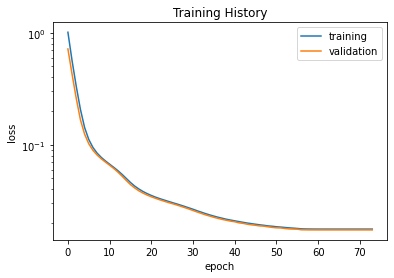

In [16]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Loss Distributions

In [17]:
labels = ['W', 'Z', 'top']

In [18]:
anomaly = [features_W, features_Z, features_t]
predictedQCD = autoencoder.predict(X_test)
predicted_anomaly = []
for i in range(len(labels)):
    predicted_anomaly.append(autoencoder.predict(anomaly[i]))

In [19]:
def mse(data_in, data_out):
    mse = (data_out-data_in)*(data_out-data_in)
    # sum over features
    mse = mse.sum(-1)
    return mse    

In [20]:
lossQCD = mse(X_test, predictedQCD)
loss_anomaly = []
for i in range(len(labels)):
    loss_anomaly.append(mse(anomaly[i], predicted_anomaly[i]))

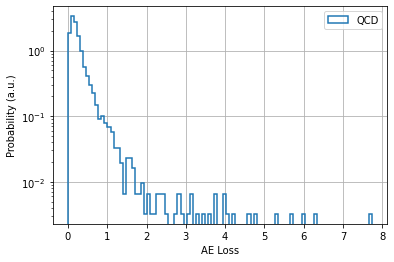

In [21]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

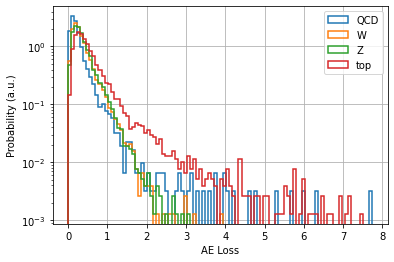

In [22]:
maxScore = np.max(lossQCD)
# plot QCD
plt.figure()
plt.hist(lossQCD, bins=100, label='QCD', density=True, range=(0, maxScore), 
         histtype='step', fill=False, linewidth=1.5)
for i in range(len(labels)):
    plt.hist(loss_anomaly[i], bins=100, label=labels[i], density=True, range=(0, maxScore),
            histtype='step', fill=False, linewidth=1.5)
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Building the ROC Curves

(10015,) (3982,)
(13997,) (13997,)
(10037,) (3982,)
(14019,) (14019,)
(10040,) (3982,)
(14022,) (14022,)


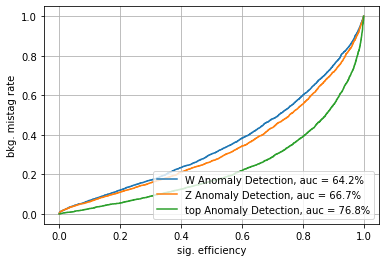

In [23]:
from sklearn.metrics import roc_curve, auc
plt.figure()
targetQCD = np.zeros(lossQCD.shape[0])
for i, label in enumerate(labels):
        print(loss_anomaly[i].shape, targetQCD.shape)
        trueVal = np.concatenate((np.ones(loss_anomaly[i].shape[0]),targetQCD))
        predVal = np.concatenate((loss_anomaly[i],lossQCD))
        print(trueVal.shape, predVal.shape)
        fpr, tpr, threshold = roc_curve(trueVal,predVal)
        auc1= auc(fpr, tpr)
        plt.plot(tpr,fpr,label='%s Anomaly Detection, auc = %.1f%%'%(label,auc1*100.))
#plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()